# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model).

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset

In [3]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist; 

Using TensorFlow backend.
C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-pa

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#automatically splits 6:1.

In [5]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

(28, 28)

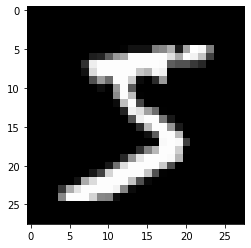

In [6]:
image = x_train[0]
fig = plt.figure()
plt.imshow(image, cmap = 'gray')
image.shape #(28 by 28, so 784 pixels)

In [7]:
x_train = x_train.reshape(x_train.shape[0], 784) #flattent the arrays for analysis
x_test = x_test.reshape(x_test.shape[0], 784)

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability, P(y\x)) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Answer 2


In [8]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(binarize= 0)
clf.fit(x_train, y_train) 
#Fit here doesn't do any prediction, rather it just creates a "bag" of counts and probabilities for each feature and each label.
#predict is what actually uses the Naive Bayes model, to calculate the likelihoods for each feature in the given vector(s).

BernoulliNB(binarize=0)

##### 1) Average Picture:

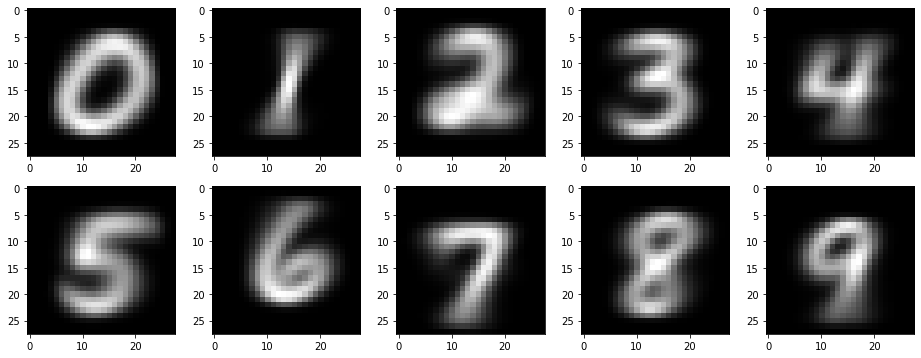

In [13]:
fig = plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)    
    images = np.mean(x_train[y_train == i], axis =0).reshape(28,28)
    plt.imshow(images, 'gray')


##### 2) Random Generation

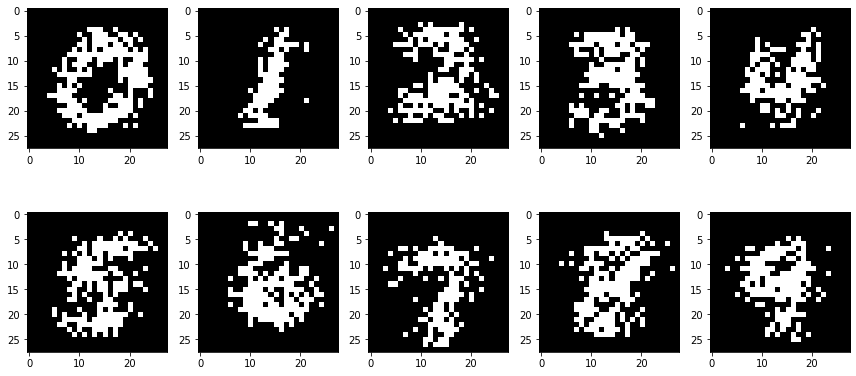

In [17]:
#need to generate an image
fig = plt.figure(figsize= (12,6))
for n in range(10):
    plt.subplot(2,5,n+1)
    prob = np.exp(clf.feature_log_prob_[n])
    random_nums = np.random.rand(len(clf.feature_log_prob_[n]))
    digits = []


    for i in range(len(prob)):
        #The probability of a pixel being black in a digit class is high (likely part of a given class). Given a random number 'i', 
        # the more likely that this area is to be part of a class, the more likely that a random number 'i' will be smaller than that probability.
        if random_nums[i] <= prob[i]:
            digits.append(1)
        else:
            digits.append(0)
    plt.imshow(np.array(digits).reshape(28,28), cmap= 'gray')
plt.tight_layout()

##### 3) Prediction and Accuracy

accuracy: 0.8413,
confusion matrix: 


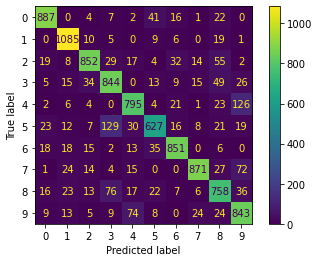

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
y_pred = clf.predict(x_test)
conf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
#accuracy = np.diagonal(conf).sum() / len(y_test)
print(f'accuracy: {acc},\nconfusion matrix: \n{conf}')

Results Summary:

Our classifier correctly classified each image 84% of the time. This is good, however, improvements could be made. We made an assumption that any digit above 0 should be converted into a 1. However, we can make a better threshold for our binomial conversion, to make our model more accurate. By raising the threshold (even for each individual class differently) we can remove outliers for each class, and more heavily weigh the pixels which are more "solidly" a part of each class, as opposed to the edges. The pixel value has 256 options [0-255], and we binarize it here with zeros of 0,1. I believe we can calculate the mean values of the pixels for each figure, and then binarize it according to this value, and it will be more accurate.

An additional way to find the optimal threshold for binarization, is to divide the trainning set into train and validation sets (maybe using k-fold cross validation), estimate the accuracy for different threshold values, and evaluate which would be the best threshold based on the resulting accuracy. 

## 2. Classifing Text Documents using Multinomial Naive Bayes
We will classify the "20 newsgroups" data set using out own naive bayes classifier, and then compare it to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.

Order of Operations:
* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english'), and chain using a `Pipeline`
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`. If there are differences try to think why
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).


a) Load the data and relevant packages

In [20]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [25]:
train_news = fetch_20newsgroups(remove = ('headers', 'footers', 'quotes'), shuffle = True)
test_news = fetch_20newsgroups(subset= 'test', remove = ('headers', 'footers', 'quotes'))

b) Create the class

In [22]:
class NaiveBayes():
    """ DIY binary Naive Bayes classifier based on categorical data """

    def __init__(self, alpha=1.0):
        """ """
        # self.prior = None
        # self.word_counts = None
        # self.lk_word = None
        self.alpha = alpha
        # self.is_fitted_ = False

    def fit(self, X: np.ndarray, y: np.ndarray):

        self.classes = np.unique(y) #len(classes)
        self.X_by_class = np.array([X[y == c] for c in self.classes])
        self.prior = np.array([X_class.shape[0] / len(self.classes) for X_class in self.X_by_class])

        self.word_counts = []
        self.lk_words = []
        for matrix_per_class in self.X_by_class:
            word_count = np.array(np.sum(matrix_per_class, axis=0)  + self.alpha).reshape(-1,1) #added dimension while creating array, reshape gets rid of it.
            self.word_counts.append(word_count)

            lk_word = word_count / np.sum(word_count)
            self.lk_words.append(lk_word)


    def predict_log_proba(self, x):
        self.log_probs_perClass = [] #Not sure which order to do htis in. Getting the wrong shape of 300,20. Not sure where 300 comes from.
        for i, text in enumerate(x.toarray()): #input is 
            text_probs = []
            for c in self.classes:
                word_exists = text.astype(bool)
                lk_words_present = self.lk_words[c].reshape(1,-1)[word_exists.reshape(1,-1)] #get the value in location where there is a value (as opposed to 0)
                text_probs.append(np.sum(np.log(lk_words_present)) + np.log(self.prior[c])) 
            self.log_probs_perClass.append(text_probs)
        return self.log_probs_perClass


    def predict(self, x):
        log_probabilities = self.predict_log_proba(x) #take out self?
        return np.argmax(log_probabilities, axis = 1)

c) Accuracy and Classfication Report

In [148]:
X = train_news.data
y = train_news.target

test_x = test_news.data
test_y = test_news.target

Create Pipeline

In [45]:
pipeline = make_pipeline(CountVectorizer(stop_words= 'english'), NaiveBayes(alpha = 0.1))
pipeline.fit(X, y)
y_pred = pipeline.predict(test_x)
accuracy_score(test_y, y_pred)

0.6548061603823686

In [151]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.53      0.52       319
           1       0.55      0.72      0.62       389
           2       0.33      0.00      0.01       394
           3       0.52      0.71      0.60       392
           4       0.62      0.68      0.65       385
           5       0.74      0.73      0.73       395
           6       0.83      0.73      0.77       390
           7       0.73      0.73      0.73       396
           8       0.76      0.75      0.75       398
           9       0.90      0.78      0.84       397
          10       0.59      0.84      0.69       399
          11       0.74      0.74      0.74       396
          12       0.67      0.58      0.62       393
          13       0.82      0.77      0.80       396
          14       0.75      0.74      0.75       394
          15       0.58      0.82      0.68       398
          16       0.57      0.64      0.60       364
          17       0.80    

In [40]:
MNB = make_pipeline(CountVectorizer(stop_words= 'english'), MultinomialNB())
MNB.fit(X,y)
orig_score = accuracy_score(test_y, MNB.predict(test_x))
orig_score

0.6343600637280935

d) Plot the Learning Curve

In [154]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(MultinomialNB(), CountVectorizer(stop_words= 'english').fit_transform(X), y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

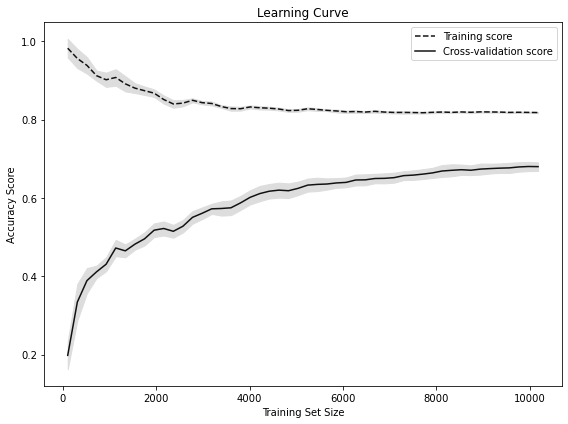

In [155]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize= (8,6))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()



We can see that our model is in high bias regime

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(MultinomialNB(), test_x, test_y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))


e)  Optimization

In [32]:
X = train_news.data
y = train_news.target

test_x = test_news.data
test_y = test_news.target

scores = []
ranges = np.linspace(0.01, 1, 20)
for i in ranges:
    MNB = make_pipeline(CountVectorizer(stop_words= 'english', max_df= i), MultinomialNB())
    MNB.fit(X,y)
    scores.append(accuracy_score(test_y, MNB.predict(test_x)))
    

In [41]:

print(f'The optimal max_df is {ranges[np.argmax(scores)]} , which produces an accuracy score of {np.max(scores)}')
print(f'This is an improvement from our original accuracy score, which was {orig_score}')

The optimal max_df is 0.06210526315789474 , which produces an accuracy score of 0.6427243759957515
This is an improvement from our original accuracy score, which was 0.6343600637280935


Another optimization we made, was reducing alpha (in our own Naive classifier) from 1 to 0.1, for the laplace smoothing. This gave our accuracy score a boost of 3%.